

<font size = "5"> **Chapter 4: [Spectroscopy](CH4-Spectroscopy.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />



# Chemical Composition in Core-Loss Spectra

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_08-Chemical_Compostion.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Spectroscopy/CH4_08-Chemical_Compostion.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.


## Content

Quantitative determination of composition in a core-loss EELS spectrum

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of the here introduced model-based quantification method.


## Load important packages

### Check Installed Packages


In [10]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('sidpy') < '0.0.5':
        print('installing sidpy')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
    if test_package('pyTEMlib') < '0.2021.4.20':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [11]:
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:    
    %pylab --no-import-all notebook
    %gui qt
    
import warnings
warnings.filterwarnings('ignore')

## We need to import a few important additional function from matplotlib, 
## because we want to demonstrate a few more hidden functionalities of the EELS_tools of pytTEMlib.
from matplotlib.widgets import Cursor
from matplotlib.patches import Rectangle
from matplotlib.widgets import SpanSelector
from scipy.ndimage.filters import gaussian_filter

## import the configuration files of pyTEMlib (we need access to the data folder)
import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.eels_tools as eels
import pyTEMlib.interactive_eels as ieels

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2021.04.02


## Chemical Composition

>
> We discuss first the conventional method of EELS chemical compoisition determination
>

In this chapter we use the area under the ionization edge to determine the chemical composition of a (small) sample volume. 
The equation used to determine the number of atoms per unit volume $N$ (also called areal density) is:
\begin{equation}
I_{edge}(\beta, \Delta E) = N * I_{0}(\beta) * \sigma_{edge}(\beta, \Delta E)
\end{equation}

$I_0$ is the number of electrons hitting the sample, and so directly comparable to the beam current.

The equation can be approximated assuming that the spectrum has not been corrected for single scattering:
\begin{equation} 
I_{edge}(\beta, \Delta E) = N * I_{low-loss}(\beta,\Delta E) *  \sigma_{edge}(\beta, \Delta E)
\end{equation}
where $\beta$ is the collection angle and $\sigma_{edge}$ is the **partial** cross--section (for energy window $\Delta E$) for the core--loss excitation.

The integration interval $\Delta E$ which defines  $I_{edge}(\beta, \Delta E)$ and $I_{low-loss}$ is shown in figure below. 

<img title="chemical_composition" width="50%" alt="chemical_composition" src="images/edge2.jpg">

*Valence--loss, core--loss edges and background of SrTiO$_3$]{\label{fig:edge2} Ti-L$_{2,3}$ and O-K (right) core--loss edges and background of SrTiO$_3$. The valence-loss spectrum with the zero--loss $I_{zero-loss}$ and low--loss intensities $I_{low-loss} $ to be used in the quantification are displayed in the background.*

If we cannot determine the intensity of the zero-loss peak  $I_{zero-loss}$  or of the low-loss area $I_{low-loss}$, we still can determine relative chemical compositions of two elements $a$ and $b$ considering that:

\begin{equation}
\frac{N_a}{N_b} = \frac{I_{e_a}(\beta, \Delta E)}{I_0 \sigma_{e_a}(\beta, \Delta E)} \frac{I_0 \sigma_{e_b}(\beta, \Delta E) } {I_{e_b}(\beta, \Delta E)} \nonumber 
\end{equation}

\begin{equation}
\frac{N_a}{N_b}=  \frac{I_{e_a}(\beta, \Delta E)\sigma_{e_b}(\beta, \Delta E) } 
{I_{e_b}(\beta, \Delta E)\sigma_{e_a}(\beta, \Delta E) } 
\end{equation}

and the value $I_0$ cancels out.

The integration windows for the two edges $\Delta E$ should be the same, but can be chosen differently as long as we use a different cross-section $\sigma$ as well. For that case we get:

\begin{equation} \
\frac{N_a}{N_b} =  \frac{I_{e_a}(\beta, \Delta E_a)\sigma_{e_b}(\beta, \Delta E_b) } 
{I_{e_b}(\beta, \Delta E_a)\sigma_{e_a}(\beta, \Delta E_a) } 
\end{equation}

Note, that the use of different integration windows usually results in a larger error of the quantification.

In order to use the above equation we first  have to determine the background under the edge.
This background  is then subtracted from the spectrum.
Then we integrate over the different parts of the spectrum to determine the integrals (sums) of $I_{edge}$,  and $I_{zero-loss}$, or  $I_{low-loss} $ (depending whether we did a SSD first or not).
After that we have to determine the cross-section ([notebook](CH4_07-Working_with_X-Sections.ipynb)) for each edge for the parameter $\beta$ and $\Delta E$.

### Background Fitting

The core-loss edges occur usually at energy-losses higher than 100 eV, superimposed to a monotonic decreasing background. For quantification of the chemical composition we need the area under the edge of a spectrum, and therefore, need to subtract the intensity of the background under the edge. Here we discuss several methods of how to determine the intensity of the background under the  edge.

The high energy ``tail`` of the plasmon peak follows the power law $A E^{-r}$. The parameter is varies widely and is associated with the intensity of the background. $E$ is the energy loss. The exponent $r$ gives the slope and should be between 2-6. The value $r$ usually decreases with increasing specimen thickness, because of plural-scattering contributions. $r$ also decreases with increasing collection angles $\beta$, but increases with increasing energy--loss.

>
>Consequently, we have to determine the parameters $A$ and $r$ for each ionization edge.
>

The fitting of the power law $A E^{-r}$ (to determine $A$ and $r$) is usually done in an area just before the edge, assuming that the background follows the same power law under the edge.
This fit can only work if the detector dark current and gain variation is corrected prior to the analysis.


A standard technique is to match the pre--edge background $J(E)$ to a function $F(E)$ (here the power law) whose parameter (here $A$ and $r$) minimize the quantity:
\begin{equation} 
\chi^2 = \sum \limits_{i} \left[  \frac{J_i - F_i}{\sigma_i} \right]^2
\end{equation}
where $i$ is the index of the channel within the fitting region and $\sigma_i$ represents the statistical error (standard deviation) of the intensity in that channel.

The value $\sigma_i$ is often considered constant (for example $1/3$ or $e^{-1}$). For our problem, the quantum mechanical shot noise is adequate 
\begin{equation} 
\sigma_i = \ln(J_i - \sqrt{J_i}) - \ln(J_i) \approx \sqrt{J_i} 
\end{equation}
where we assume that $J_i$ is in number of electrons and not in counts (number of electrons times a conversion factor).

In the figure below, we see the result and the output of the background fit (plus subtraction).

<img title="chemical_composition" width="50%" alt="chemical_composition" src="images/background.jpg">

* Background fit on a spectrum of SrTiO$_3$]{\label{fig:background} Background fit on a spectrum of SrTiO$_3$. The $A$ and $r$ parameter together with the normalized (reduced) $\chi^2_n$ parameter is displayed in the {\bf Results} window.*

### Background Fitting: Spatial Difference



We can use also an experimentally determined background, if impurity or dopant atoms are present in confined areas only. Then,  we can take two spectra: one next to this area and one at this area. The near by area will result in a spectrum without this edge and can be used as a background for quantification of the other spectrum. This method is highly accurate if the sample thickness does not change between these areas. The measurement of ppm levels of dopants and impurity atoms can achieved with this method. This Method will be more closely examined in Section Spatial-Difference

### Background Subtraction Errors

In addition to possible systematic errors, any fitted background to noisy data will be subject to to a random or statistical error.  The signal noise ration (SNR) can be defined as:

\begin{equation}
SNR = I_{edge} [\mbox{var}(I_{edge}]^{-1/2} = I_{edge}/(I_{edge}+ h \quad I_{background})^{1/2}
\end{equation}

where the dimensionless parameter $h$ represents the uncertainty of the background fit due to noise.
If the width of the integration window is sufficiently small (for example the same width as the fitting window) then this factor $h$ is relatively small. For equal windows we can approximate $h = 10$.


### Cross-Section


The cross--section gives us the weight of the edge intensity to compare to different elements or to the total number of electrons (to compute areal density).
Such a cross--sections is compared to an edge intensity in the figure below.

<img title="cross-section1" width="50%" alt="Comparison of calculated cross-section and Si-L edges" src="images/cross-section1.jpg">

*The shape of a calculated cross-section (black) is compared to the  intensity of a Si-L$_{2,3}$ and Si-$L_{1}$ edge after background subtraction (gray). The SSD--corrected spectrum (red) and the extrapolated background (light blue) are also shown. In the results window, we see the integrated edge intensity, the integrated cross-sections and the determined areal density.*

There are different methods of how to use cross-sections in the quantification of  the chemical composition from spectra:

Egerton gives in his book a tabulated list of generalized oscillator strength (GOS) for different elements. The values for different integration windows $\Delta E$ can be linearly extrapolated for other integration window widths. The GOS have to be extrapolated for the chosen integration window and converted to cross--sections. The GOS are calculated with the Bethe theory in Hydrogenic approximation (see below in chapter \ref{sec:cross-section-calculate}
### Calculation of the Cross--Section

There are two methods in  the literature to calculate the cross--section. One is the one where we assume s states in free atoms and is called Hydrogenic approximation and one which approximates  the free atoms a little more detailed: the Hatree-Slater method. 

Both methods are based on free atom calculations, because of the strong bonding of the core--electrons to the nucleus, band-structure (collective) effects can be neglected.



The figure below compares the cross--sections of these two approximations (with a background added) to an experimental spectrum.

<img title="cross-section1" width="50%" alt="The shape of a Hydrogenic and Hatree--Slater cross-section" src="images/cross-section-both.jpg">

*The shape of a Hydrogenic (green) and Hatree--Slater (blue) cross-section (with a background added) is compared to an experimental (SSD-corrected) spectrum of Si.*

### Summary
The power law is not really correct for any larger energy interval, which results in a change of the $r$ exponent throughout the spectrum's energy range.
	
A polynomial of 2$^{nd}$ order can be used to fit the spectrum, but often leads to strong oscillations in the extrapolated high energy part. 

The exact slope of the extrapolated background depends on pre-edge features and noise
	
>
>Generally the above described classic method of quantification is often non-reproducible, and results in errors often in excess of 100%.
>

In the following we will work with a model based method that reduces the artefacts, increases reproducibility and improves the error to about 3 atom % absolute. 

## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

single_exposure_time : 3.0
exposure_time : 63.0
number_of_frames : 21
collection_angle : 33.0
convergence_angle : 30.0
acceleration_voltage : 200000.0
microscope : Unknown


<IPython.core.display.Javascript object>


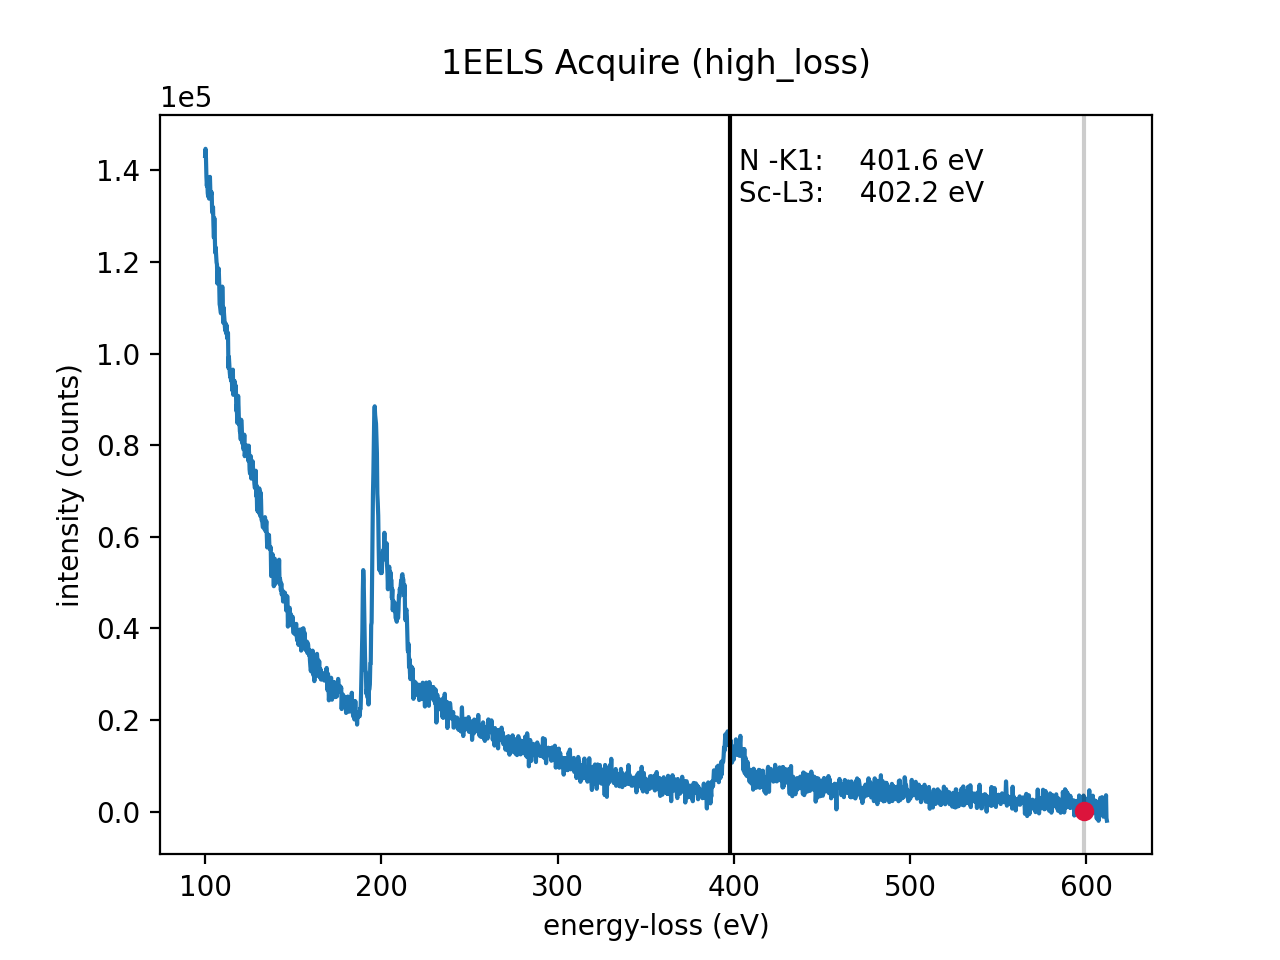

In [12]:
try:
    current_channel.file.close()
except:
    pass
# Load file
file_name = '../example_data/1EELS Acquire (high-loss).dm3'
main_dataset = ft.open_file(file_name)#os.path.join(current_directory,filename))
current_channel = main_dataset.h5_dataset.parent.parent


if main_dataset.data_type.name != 'SPECTRUM':
    print('NOT what we want here')
else:
    main_dataset.metadata = eels.read_dm3_eels_info(main_dataset.original_metadata)
    main_dataset.metadata['exposure_time'] = main_dataset.metadata['single_exposure_time'] * main_dataset.metadata['number_of_frames']
    main_dataset.view_metadata()

main_dataset.plot()    

### Which elements are present

To determine which elements are present we add a cursor to the above plot (see [Working with Cross-Sections](CH4_07-Working_with_X-Sections.ipynb) for details) and with a left (right) mouse-click, we will get the major (all) edges in the vincinity of the cursor.

In the example we note that the N-K edge of this boron nitride sample is not at 400keV. We have to adjust the energy-scale. <br>(THIS SHOULD NOT HAPPEN IN NORMAL SPECTRA AND IS FOR DEMONSTRATION ONLY)

In [13]:
maximal_chemical_shift = 5
energy_scale = main_dataset.energy_loss
cursor = ieels.EdgesAtCursor(main_dataset.view.axis, energy_scale,main_dataset,maximal_chemical_shift)

Let's correct the energy scale of the example spectrum.

Again a shift of the enrrgy scale is normal but not a discripancy of the dispersion.

### Probability scale of y-axis

We need to know the total amount of electrons involved in the EELS spectrum 

There are three possibilities:
- the intensity of the low loss will give us the counts per acquisition time
- the intensity of the beam in an image
- a direct measurement of the incident beam current

Here we got the low-loss spectrum. For the example please load **1EELS Acquire (low-loss).dm3** from the *example data* folder.

single_exposure_time : 0.01
exposure_time : 0.21
number_of_frames : 21
collection_angle : 33.0
convergence_angle : 30.0
acceleration_voltage : 200000.0
microscope : Unknown


<IPython.core.display.Javascript object>


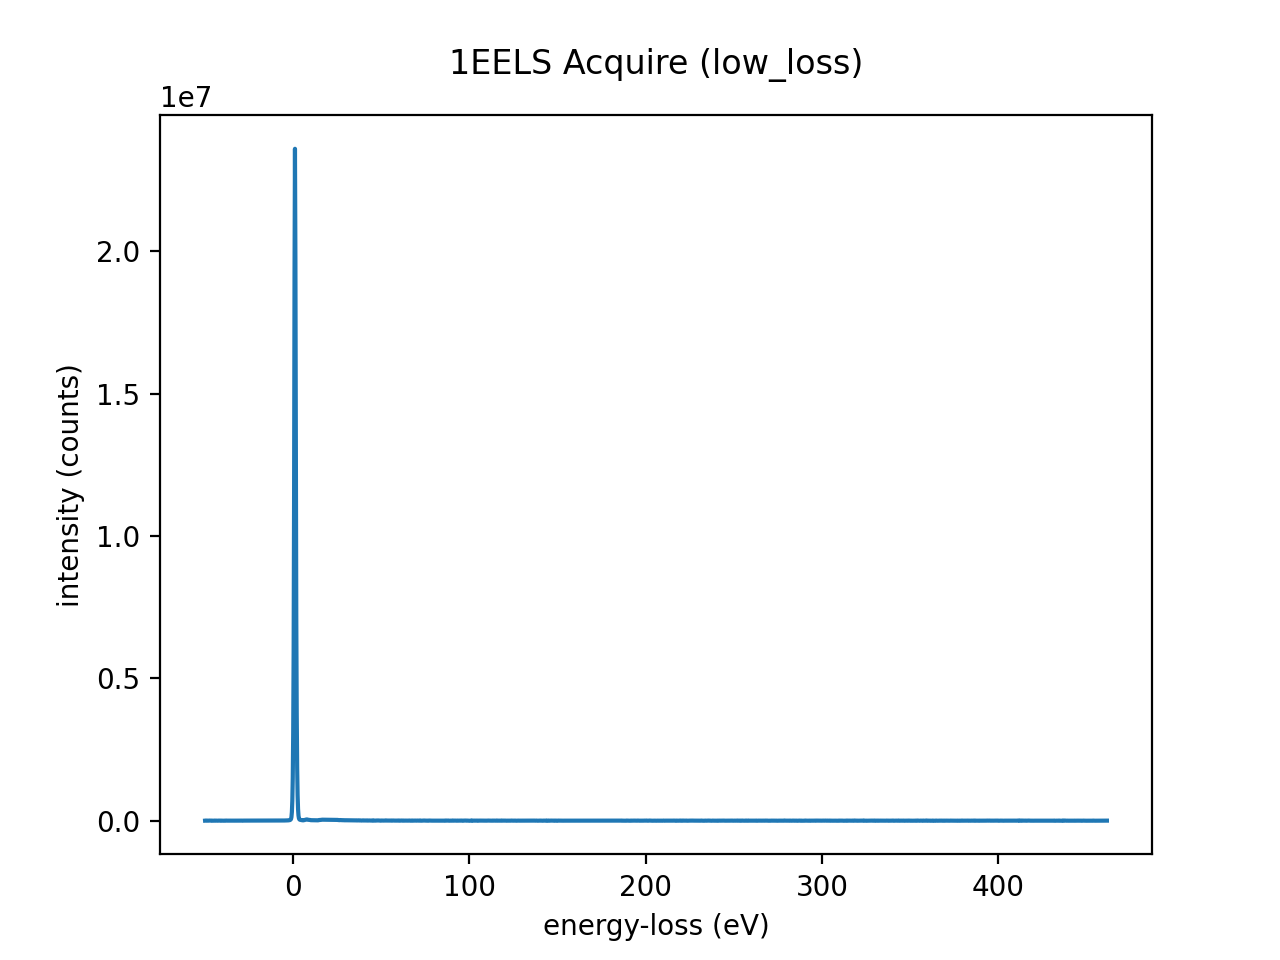

In [14]:
ll_dataset = ft.open_file('../example_data/1EELS Acquire (low-loss).dm3')
ll_dataset.h5_dataset.file.close()
ll_dataset.metadata = eels.read_dm3_eels_info(ll_dataset.original_metadata)
ll_dataset.metadata['exposure_time'] = ll_dataset.metadata['single_exposure_time'] * ll_dataset.metadata['number_of_frames']
ll_dataset.view_metadata()
ll_dataset.plot()

### Intensity to Probability Calibration

 We need to calibrate the number of counts with the integration time of the spectrum.

115700152 counts in  0.21sec
incident beam current of core--loss spectrum is 11721591600 counts


<IPython.core.display.Javascript object>


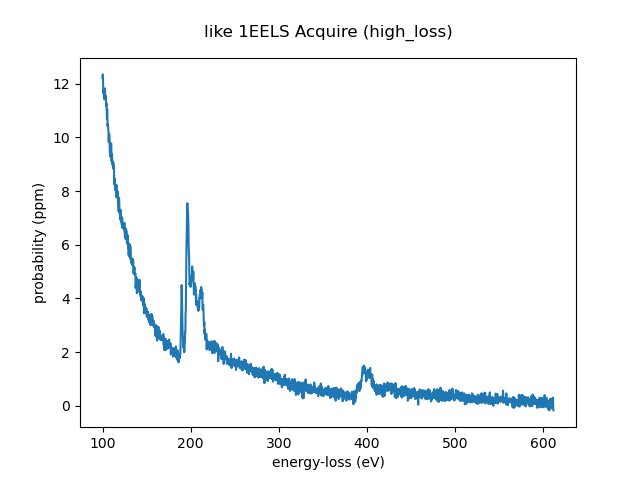

In [5]:
print(f"{ll_dataset.sum():.0f} counts in  {ll_dataset.metadata['exposure_time']:.2f}sec")
I0 = ll_dataset.sum()/ll_dataset.metadata['exposure_time']

I0 = main_dataset.sum()/ll_dataset.metadata['exposure_time']*main_dataset.metadata['exposure_time']
print(f"incident beam current of core--loss spectrum is {I0:.0f} counts")

main_dataset.metadata['intentsity_scale_ppm'] = 1e6/I0
main_dataset.metadata['incident_beam_current_counts'] = I0

spectrum = main_dataset*main_dataset.metadata['intentsity_scale_ppm']
spectrum.quantity = 'probability'
spectrum.units = 'ppm'
spectrum.plot()

## Components of a core loss spectrum

-background

-absorption edges

### Plotting of cross sections and spectrum
please note that spectrum and cross sections are not on the same scale

<IPython.core.display.Javascript object>


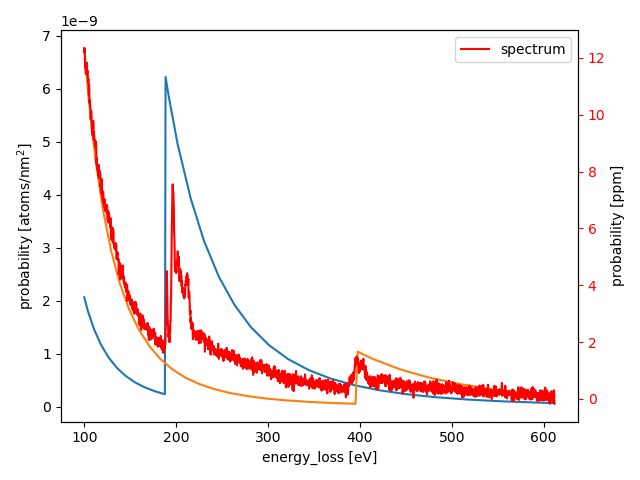

In [7]:

B_Xsection = eels.xsec_xrpa(energy_scale, 200, 5, 10. )/1e10  
N_Xsection = eels.xsec_xrpa(energy_scale, 200, 7, 10. ,shift=-6)/1e10       #  xsec  is in barns = 10^28 m2 = 10^10 nm2

fig, ax1 = plt.subplots()

ax1.plot(energy_scale, Ti_Xsection, label='Ti X-section' )
ax1.plot(energy_scale, O_Xsection, label='O X-section' )
ax1.set_xlabel('energy_loss [eV]')
ax1.set_ylabel('probability [atoms/nm$^{2}$]')

ax2 = ax1.twinx()
ax2.plot(energy_scale, spectrum, c='r', label='spectrum')
ax2.tick_params('y', colors='r')
ax2.set_ylabel('probability [ppm]')
#plt.xlim(100,500)
plt.legend();
fig.tight_layout();




### Background
The other ingredient in a core loss spectrum is the background

The backgrund consists of
- ionization edges to the left of the beginning of the spectrum (offset)
- tail of the plasmon peak (generally a power_law with $\approx A* E^{-3}$)

Here we approximate the background in an energy window before the first ionization edge in the spectrum as a power law with exponent $r\approx 3$

Power-law background with amplitude A: 46400388.8 and exponent -r: 3.27


<IPython.core.display.Javascript object>


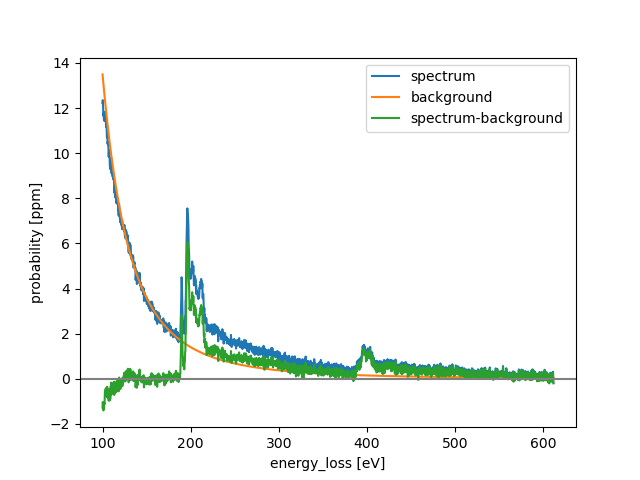

In [8]:
from scipy.optimize import leastsq  ## leastsqure fitting routine fo scipy


# Determine energy window in pixels
bgdStart = 120
bgdWidth = 40
offset = energy_scale[0]
dispersion = energy_scale[1]-energy_scale[0]
startx = int((bgdStart-offset)/dispersion)
endx = startx + int(bgdWidth/dispersion) 

x = np.array(energy_scale[startx:endx])
y = np.array(spectrum[startx:endx])

# Initial values of parameters
p0 = np.array([1.0E+20,3])

## background fitting 
def bgdfit(p, y, x):
    err = y - (p[0]* np.power(x,(-p[1])))
    return err
p, lsq = leastsq(bgdfit, p0, args=(y, x), maxfev=2000)
print(f'Power-law background with amplitude A: {p[0]:.1f} and exponent -r: {p[1]:.2f}')

#Calculate background over the whole energy scale
background = p[0]* np.power(energy_scale,(-p[1]))

plt.figure()

plt.xlabel('energy_loss [eV]')
plt.ylabel('probability [ppm]')

plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, background, label='background')
plt.plot(energy_scale, spectrum-background, label='spectrum-background')
plt.legend();
plt.axhline(0, color='gray')

## Fitting a Spectrum

We are revisiting the above the fundamental equation of the chemical composition:

We already calibrated the cross section in per $nm^2$ and so if we start again from the fundamental equation:

\begin{equation}
I_{edge}(\beta, \Delta E) = N I_{0}(\beta) \sigma_{edge}(\beta, \Delta E)
\end{equation}

and as above we calibrate the intensity of the spectrum by $I_{spectrum}/I_0$ then we get::

\begin{equation}
\frac{I_{edge}(\beta, \Delta E)}{I_0} = I^{norm}_{edge}  = N \sigma_{edge}(\beta, \Delta E)
\end{equation}

and if we fit the calibrated intensity with the cross section then we can replace$I^{norm}_{edge}$ by a fitting value $q_{edge}$ multiplied by cross section $\sigma$:


$$
N =  \frac{I_{edge}(\beta, \Delta E)/I_0}{\sigma_{edge}(\beta, \Delta E)}  = \frac{I^{norm}_{edge}}{\sigma_{edge}(\beta, \Delta E)} = \frac{q_{edge} * \sigma_{edge}(\beta, \Delta E)}{\sigma_{edge}(\beta, \Delta E)} = q_{edge}
$$ 

and N is in atoms per nm$^2$.

So a fit to a callibrated spectrum as above, will get us a ``fitting parameter`` which is an ``areal density`` (which is a legitimate thermodynamic quantity).

And for the relative composition we get:
$$
\frac{N_a}{N_b}= \frac{q_a}{q_b}
$$

In the following we will do this kind of a fit by:
- calibrate the intensity in the spectrum (in ppm)
- using  cross section in units of nm$^2$


>
> Please note that for the relative composition , the $I_0$ will fall out and so a fit to a spectrum without calibrated intensity will still give the relative intensity accurately.
>

### Preparing the fitting mask

Our theoretical cross sections do not include any solid state effects (band structure) and so the fine structure at the onset of the spectra must be omitted in a quantification.

These parts of the spectrum will be simply set to zero. We plot the masked spectrum that will be evaluated.

In [1]:
energy_scale = main_dataset.energy_loss*1.03-3

dispersion = (energy_scale[1] - energy_scale[0])
offset = energy_scale[0]
startx = int((bgdStart-offset)/dispersion)

mask = np.ones(len(energy_scale))
mask[0 : int(startx)] = 0.0;

edges = {}
edges['1'] = {}
edges['1']['Z']=5
edges['1']['symmetry']= 'K1'
edges['2'] = {}
edges['2']['Z']=7
edges['2']['symmetry']= 'K1'

for key in edges:
    print((eels.get_x_sections(edges[key]['Z']))[edges[key]['symmetry']])
    edges[key]['onset'] = (eels.get_x_sections(edges[key]['Z']))[edges[key]['symmetry']]['onset']
    if key == '2':
        edges[key]['onset'] = 390
        print('onset')
    edges[key]['onset_pixel'] = int((edges[key]['onset'] -offset)/dispersion)
    edges[key]['start_exclude'] = int((edges[key]['onset']-5  - offset)/dispersion)
    edges[key]['end_exclude']   = int((edges[key]['onset']+50 - offset)/dispersion)
    print(key)
    if key == '2':
        edges[key]['onset'] = 400
        print('onset')
    mask[edges[key]['start_exclude']:edges[key]['end_exclude']] = 0.0



plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, spectrum*mask, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

NameError: name 'main_dataset' is not defined

### The Fit

The function **model** just sums the weighted cross-sections and the background.

The background consists of the power-lawbackground before plus a polynomial component allowing for *a variation of the exponent $r$ of the power-law*.

The least square fit is weighted by the noise according to Poison statistic $\sqrt{I(\Delta E)}$.

>
>Please note that the cross sections are for single atoms only and do not cover any solid state effects vsible as strong peaks in the first 50 eV or so past the onset.
>
> We exclude those parts from the fits.

<IPython.core.display.Javascript object>


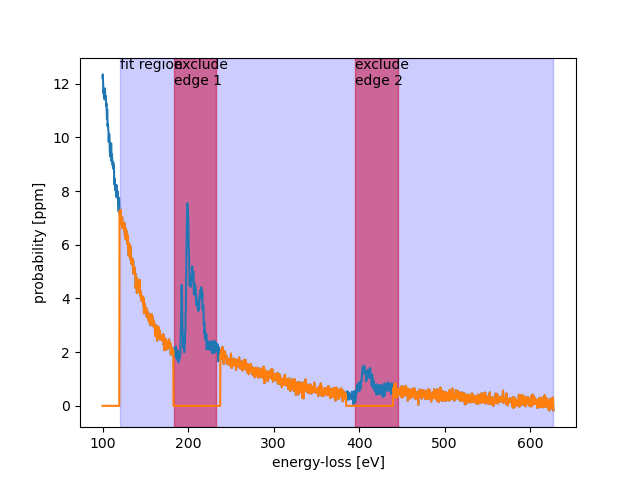

1
2


In [10]:
plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, spectrum*mask, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

regions = ieels.RegionSelector(plt.gca())

for key in edges:
    print(key)
    regions.set_regions(str(key),edges[key]['onset']-5, 50.)
                                  
regions.set_regions('fit region',bgdStart, energy_scale[-1]-bgdStart)

In [11]:
region_tags = regions.get_regions()
startx = int((region_tags['fit_area']['start_x']-offset)/dispersion)

print(region_tags)

{'1': {'start_x': 183.0, 'width_x': 50.0}, '2': {'start_x': 395, 'width_x': 50.0}, 'fit_area': {'start_x': 120, 'width_x': 507.10249999999996}}


In [12]:
edges

{'1': {'Z': 5,
  'symmetry': 'K1',
  'onset': 188.0,
  'onset_pixel': 341,
  'start_exclude': 322,
  'end_exclude': 535},
 '2': {'Z': 7,
  'symmetry': 'K1',
  'onset': 400,
  'onset_pixel': 1126,
  'start_exclude': 1106,
  'end_exclude': 1320}}

In [13]:
region_tags = regions.get_regions()

mask = np.ones(main_dataset.shape)

#startx = np.searchsorted(tags['energy_scale'],region_tags['fit_area']['start_x'])
                            
mask[0:startx] = 0.0

for key in region_tags:
    end = region_tags[key]['start_x']+region_tags[key]['width_x']
    startx = np.searchsorted(energy_scale,region_tags[key]['start_x'])
    endx   = np.searchsorted(energy_scale,end)
    if key == 'fit_area':
        mask[0:startx] = 0.0
        mask[endx:-1] = 0.0
    else:
        mask[startx:endx] = 0.0



pin = np.array([1.0,1.0,.0,0.0,0.0,0.0, 1.0,1.0,0.001,5,3])
x = energy_scale

blurred = gaussian_filter(spectrum, sigma=5)

y = blurred*1e-6 ## now in probability
y[np.where(y<1e-8)]=1e-8


B_Xsection = eels.xsec_xrpa(energy_scale, 200, 5,  10. )/1e10  
N_Xsection = eels.xsec_xrpa(energy_scale, 200, 7,  10. )/1e10       #  xsec  is in barns = 10^-28 m2 = 10^-10 nm2

xsec = np.array([B_Xsection, N_Xsection])
numberOfEdges = 2

def residuals(p,  x, y ):
    err = (y-model(x,p))*mask/np.sqrt(np.abs(y))
    return err        

def model(x, p):  
    y = (p[9]* np.power(x,(-p[10]))) +p[7]*x+p[8]*x*x
    for i in range(numberOfEdges):
        y = y + p[i] * xsec[i,:]
    return y

p, cov = leastsq(residuals, pin,  args = (x,y) )
 
print(f"B/N ratio is {p[0]/p[1]:.3f}")

#the B atom areal density of a single layer of h-BN (18.2 nm−2) 
print(f" B areal density is {p[0]:.0f} atoms per square nm, which equates {abs(p[0])/18.2:.1f} atomic layers")
print(f" N areal density is {p[1]:.0f} atoms per square nm, which equates {abs(p[1])/18.2:.1f} atomic layers")



B/N ratio is 1.071
 B areal density is 420 atoms per square nm, which equates 23.1 atomic layers
 N areal density is 393 atoms per square nm, which equates 21.6 atomic layers


This result let's us pause a little. How big of and error do we have?

>
>Why is the number of B atoms not equal to the number of N atoms? 
>

Naively, we would assume an error of 7 atom%

However, the number of single atomic layers gives us a hint.

There are 23 layers of B and 24 layers of N. 

This result suggests that BN is terminated on the B and N face with a layer of B and the error is 2.5 atom%


In [8]:
print(f'The expected ratio between 23 layers of B and 22 layers of N is {23/22:.3f}')

The expected ratio between 23 layers of B and 22 layers of N is 1.045


###  Plotting of the fit


<IPython.core.display.Javascript object>


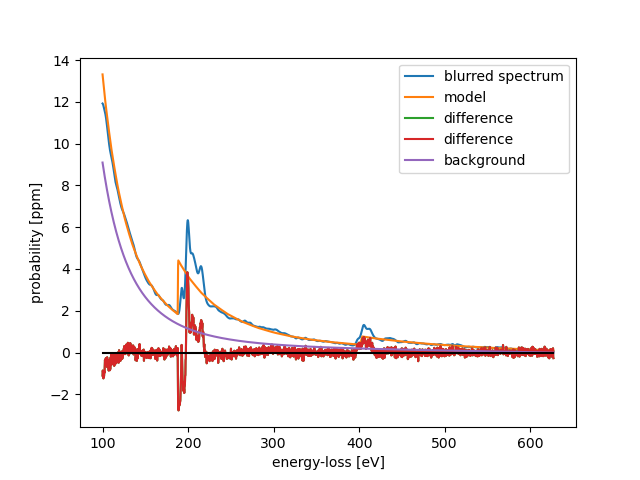

In [14]:
model_spectrum =  model(x, p)*1e6 # in ppm
model_background =  ((p[9]* np.power(x,-p[10])) +p[7]*x+p[8]*x*x)*1e6 # in ppm

plt.figure()
#plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, blurred, label='blurred spectrum')
plt.plot(x,model_spectrum, label='model')
plt.plot(x,spectrum-model_spectrum, label='difference')
plt.plot(x,(spectrum-model_spectrum), label='difference')
plt.plot(x,model_background, label='background')
plt.plot([x[0],x[-1]],[0,0],c='black')

plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]')
plt.legend();

## Summary

We use a cross section in unsits of nm$^2$ and a calibrated spectrum to fit a cross section to each edge.

The fitting parameter is then the areal density of the element.

We only fit the part of the spectrum we know which is the single atom part of the edge, and avoid to fit any solid state effects at the onset of the edge.

The interpreation of solid state effects at the onset are discussed in the [energy-loss near-edge structure (ELNES)](CH4_10-ELNES.ipynb) notebook.


## Navigation
- <font size = "3">  **Up Chapter 4: [Imaging](CH4_00-Spectroscopy.ipynb)** </font>
- <font size = "3">  **Back: [Introduction to Core-Loss](CH4_07-Introduction_Core_Loss.ipynb)** </font>
- <font size = "3">  **Next: [Analysis of Core-Loss](CH4_09-Analysis_Core_Loss.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>